# Case 1. Heart Disease Classification


* Author: Martin Rožnovják
* Last edited: 2019-02-03
* Organization: Metropolia University of Applied Sciences


## What is this?

This notebook is a school assignment for a course called *Cognitive Systems for Health Technology Applications*.

Its goal is to analyze data about cardiovascular disease (CVD) from [https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/] and to explore different neural network architectures in order to classify patients as healthy or having a CVD (binary classification only). The challenge is to to find the simplest, fastest and smallest possible model and settings that solves the problem most accurately.

## Let's get started

All necessary imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pandas import plotting

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold

import keras
import keras.backend as K

from keras.layers import Dense, Dropout, BatchNormalization

Using TensorFlow backend.


Setting options, in particular those for Matplotlib, often interferes with Jupyter's own initializations on import. Therefore, I just do it in the next cell.

In [2]:
# matplotlib
plt.rcParams['figure.figsize'] = [18, 8] # set default fiure size

# pandas
pd.options.display.precision = 3 # no need to see many decimal places and makes nicer horizontal fits :-)
pd.options.display.max_rows = 20 # make the tables more compact vertically, too

**Fetching the dataset**

In [3]:
# list descriptive column names for the dataset
# adjusted from https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names
col_names = (
    'age',      # age in years
    'sex',      # sex {1: male; 0: female}
    'cp',       # chest pain type {1: typical angina; 2: atypical angina; 3: non-anginal pain; 4: asymptomatic}
    'trestbps', # resting blood pressure (in mm Hg on admission to the hospital)
    'chol',     # serum cholestoral in mg/dl
    'fbs',      # (fasting blood sugar > 120 mg/dl) {1: true; 0: false}
    'restecg',  # resting electrocardiographic results {
                #         0: normal;
                #         1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV);
                #         2: showing probable or definite left ventricular hypertrophy by Estes' criteria }
    'thalach',  # maximum heart rate achieved
    'exang',    # exercise induced angina {1: yes; 0: no}
    'oldpeak',  # ST depression induced by exercise relative to rest
    'slope',    # the slope of the peak exercise ST segment {1: upsloping; 2: flat; 3: downsloping}
    'ca',       # number of major vessels (0-3) colored by flourosopy
    'thal',     # {3: normal; 6: fixed defect; 7: reversable defect}
    'diag',     # diagnosis of heart disease (angiographic disease status), was called "num" in the original dataset
)

# read dataset into a Pandas DataFrame
df_orig = pd.read_csv(
    r'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
    names=col_names,
    na_values='?',
    dtype='float64', # all values as float64
)

A peek at the values

In [4]:
df_orig

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diag
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0.0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3.0
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0.0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2.0
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1.0


Looks good - according to the dataset description there are supposed to be 303 rows and 14 columns, last of them being the class (diagnosis).
The order of the patients seems to be random, however, it will anyway get shuffled later on - automatically during cross validation and batch-wise during training.

Let's look a bit more into the characteristics of the data in the next cell.

In [5]:
df_orig.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diag
count,303.000,303.000,303.000,303.00,303.000,303.000,303.000,303.000,303.000,303.000,303.000,299.000,301.000,303.000
mean,54.439,0.680,3.158,131.69,246.693,0.149,0.990,149.607,0.327,1.040,1.601,0.672,4.734,0.937
std,9.039,0.467,0.960,17.60,51.777,0.356,0.995,22.875,0.470,1.161,0.616,0.937,1.940,1.229
min,29.000,0.000,1.000,94.00,126.000,0.000,0.000,71.000,0.000,0.000,1.000,0.000,3.000,0.000
25%,48.000,0.000,3.000,120.00,211.000,0.000,0.000,133.500,0.000,0.000,1.000,0.000,3.000,0.000
50%,56.000,1.000,3.000,130.00,241.000,0.000,1.000,153.000,0.000,0.800,2.000,0.000,3.000,0.000
75%,61.000,1.000,4.000,140.00,275.000,0.000,2.000,166.000,1.000,1.600,2.000,1.000,7.000,2.000
max,77.000,1.000,4.000,200.00,564.000,1.000,2.000,202.000,1.000,6.200,3.000,3.000,7.000,4.000


Based on the "count" row, we can tell that columns "ca" and "thal" have 4 and 2 missing values. Those rows can be dropped or the missing values can be filled with a median or a dummy value, but for now I will ignore them.

Also at a glance, it looks like "chol" column might have an error value or an outlier, perhaps just a person eating nothing but eggs and cheese...

I am still curious about the character of the data, so lets see a bit more.

In [6]:
print('Average for each column per diagnose:')
df_orig.groupby('diag').mean()

Average for each column per diagnose:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
diag,,,,,,,,,,,,,
0.0,52.585,0.561,2.793,129.250,242.640,0.140,0.835,158.378,0.140,0.587,1.409,0.273,3.798
1.0,55.382,0.836,3.345,133.255,249.109,0.073,1.164,145.927,0.455,1.005,1.636,0.741,5.345
2.0,58.028,0.806,3.750,134.194,259.278,0.250,0.917,135.583,0.611,1.781,1.889,1.222,6.029
3.0,56.000,0.800,3.771,135.457,246.457,0.229,1.286,132.057,0.657,1.963,1.971,1.457,6.286
4.0,59.692,0.846,3.692,138.769,253.385,0.077,1.615,140.615,0.462,2.362,2.077,1.692,6.231


A brief look suggests that, for example, last 4 columns might correlate with CVD.

In [7]:
print('Representatives per diagnose:')
df_orig['diag'].value_counts()

Representatives per diagnose:


0.0    164
1.0     55
2.0     36
3.0     35
4.0     13
Name: diag, dtype: int64

In [8]:
print("Pearson's correlations between the columns (pair-wise):")
corr = df_orig.corr('pearson')
corr

Pearson's correlations between the columns (pair-wise):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diag
age,1.000,-0.098,0.104,0.285,0.209,0.119,0.149,-0.394,0.092,0.204,0.162,0.363,0.127,0.223
sex,-0.098,1.000,0.010,-0.064,-0.200,0.048,0.022,-0.049,0.146,0.102,0.038,0.093,0.381,0.224
cp,0.104,0.010,1.000,-0.036,0.072,-0.040,0.068,-0.334,0.384,0.202,0.152,0.233,0.265,0.407
trestbps,0.285,-0.064,-0.036,1.000,0.130,0.175,0.147,-0.045,0.065,0.189,0.117,0.099,0.134,0.158
chol,0.209,-0.200,0.072,0.130,1.000,0.010,0.171,-0.003,0.061,0.047,-0.004,0.119,0.014,0.071
fbs,0.119,0.048,-0.040,0.175,0.010,1.000,0.070,-0.008,0.026,0.006,0.060,0.145,0.071,0.059
restecg,0.149,0.022,0.068,0.147,0.171,0.070,1.000,-0.083,0.085,0.114,0.134,0.128,0.025,0.184
thalach,-0.394,-0.049,-0.334,-0.045,-0.003,-0.008,-0.083,1.000,-0.378,-0.343,-0.386,-0.264,-0.280,-0.415
exang,0.092,0.146,0.384,0.065,0.061,0.026,0.085,-0.378,1.000,0.288,0.258,0.146,0.330,0.397
oldpeak,0.204,0.102,0.202,0.189,0.047,0.006,0.114,-0.343,0.288,1.000,0.578,0.296,0.341,0.504


That is quite difficult to appreciate, a plot should make it easier...

In [9]:
def plot_correlation_matrix(corr_matrix, threshold=None, figsize=(18,5)):
    """
    Plots a given correlation matrix and returns a figure.
    
    threshold: do not show values less than threshold (abs. values)
    """
    
    if threshold is not None:
        corr_matrix = corr_matrix[abs(corr_matrix) > threshold]
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    cax = ax.matshow(corr_matrix, vmin=-1, vmax=1)
    fig.colorbar(cax)
    
    ticks = np.arange(0,len(corr_matrix),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    labels = corr_matrix.columns
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    
    return fig

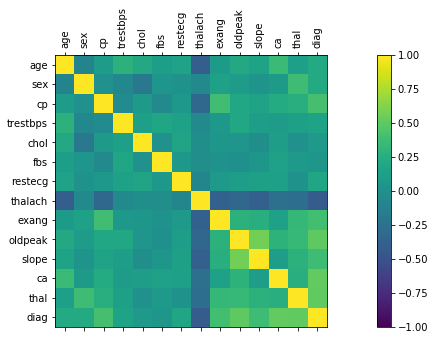

In [10]:
plot_correlation_matrix(corr);

And when not caring about tiny correlations

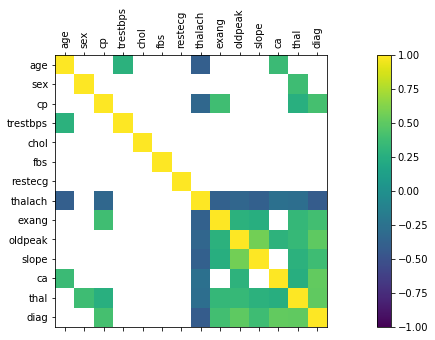

In [11]:
plot_correlation_matrix(corr, 0.25);

My girlfriend said that it looks like a man with moustache...

Column-wise histograms:


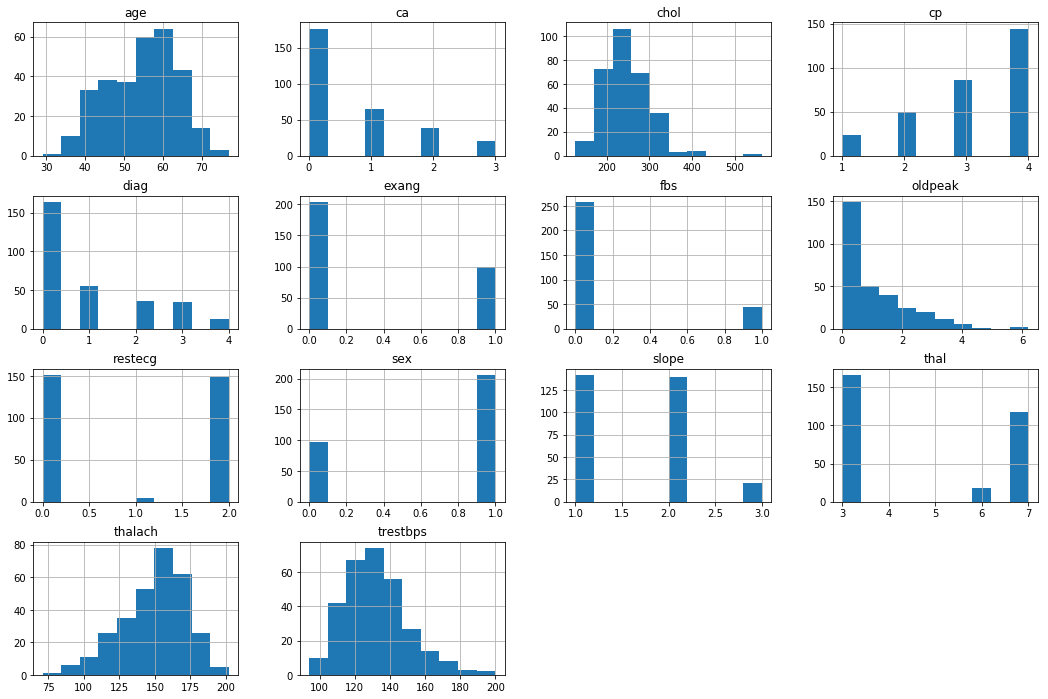

In [12]:
print('Column-wise histograms:')
df_orig.hist(figsize=(18,12));

Box-and-whiskers plot for each column:


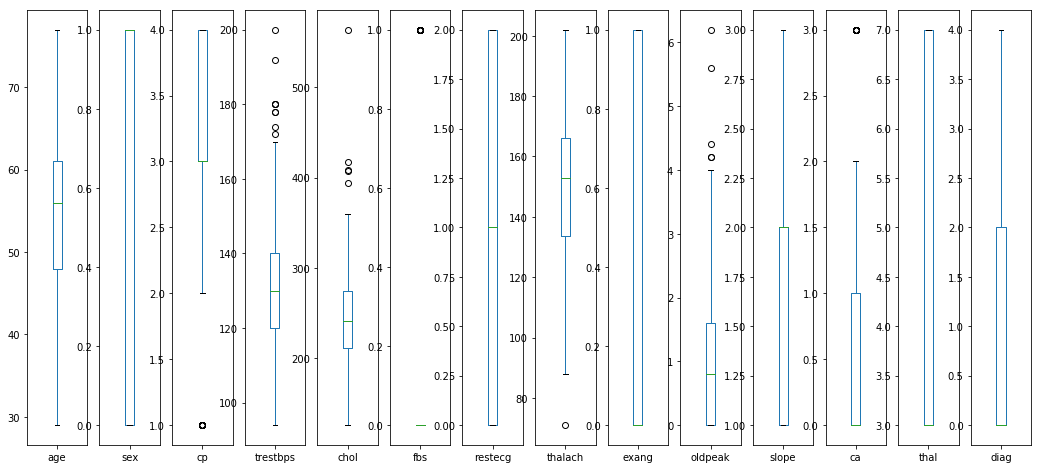

In [13]:
print('Box-and-whiskers plot for each column:')
df_orig.plot.box(subplots=True);

A way to visualize multivariable data is a plot called Andrews curves, it might or might not uncover some hidden structure and outliers. Similarly, there is a parallel coordinates plot which I will show later, because the data is still on different scales.

Andrews plot according to diagnosis:


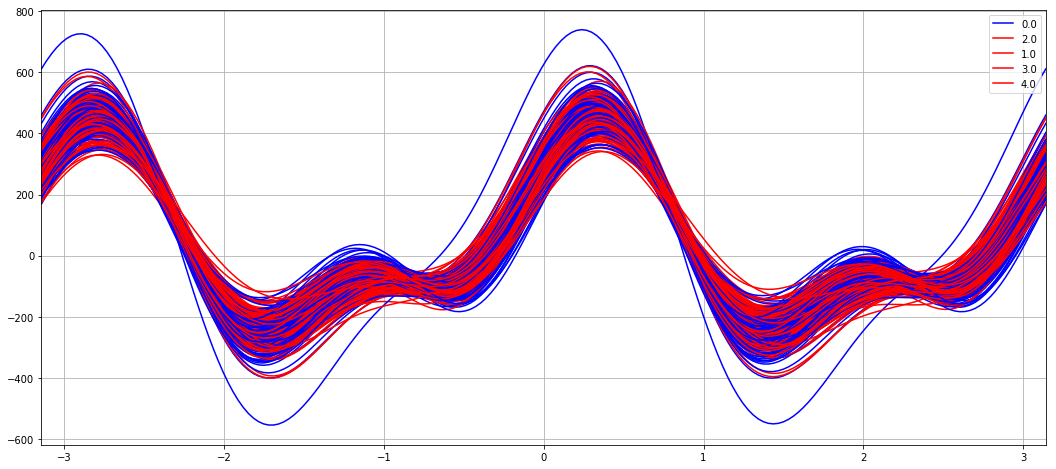

In [14]:
print('Andrews plot according to diagnosis:')
plotting.andrews_curves(df_orig, 'diag', color=['blue', 'red', 'red', 'red', 'red']);

I can see no obvious structure, except a single strong outlier. If I will have time I will try to filter outliers and compare the results.

Now, it is time to reclassify the data into healthy/unhealthy only and to shift and scale the data - shifting to zero mean and unit variance (this should play nicer with outliers than min-max scaling and I assume that changing distributions of values would not have a significat effect).

In [15]:
scaler = StandardScaler().fit(df_orig)
df_scaled = pd.DataFrame(scaler.transform(df_orig), columns=df_orig.columns)

# let 0.0 represent "healty" and 1.0 "unhealthy"
df_scaled['diag'] = (df_orig['diag'] > 0.0).astype('float64')

Box-and-whiskers again but on a single scale this time:


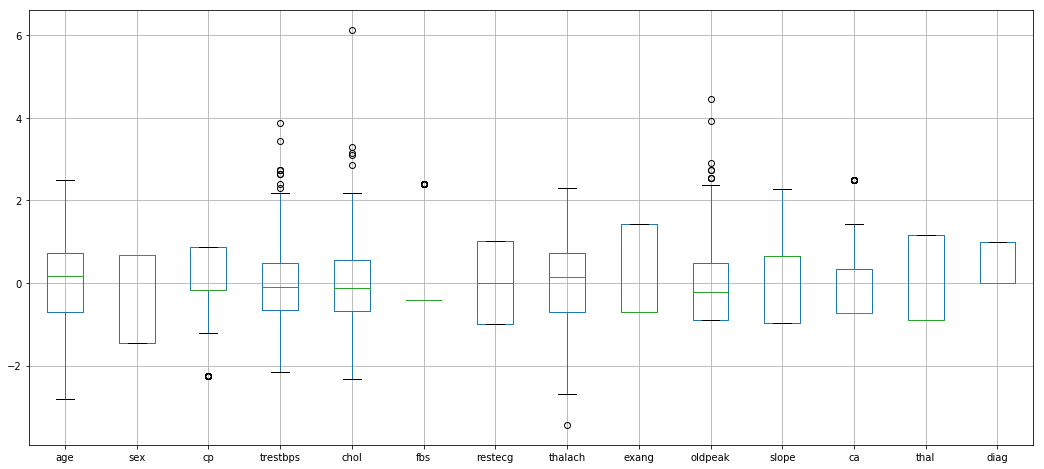

In [16]:
print('Box-and-whiskers again but on a single scale this time:')
plotting.boxplot(df_scaled);

A parallel coordinates plot follows, I will introduce some noise to the data, because lines for discrete variables often overshadow one another.

Parallel coordinates according to diagnosis:


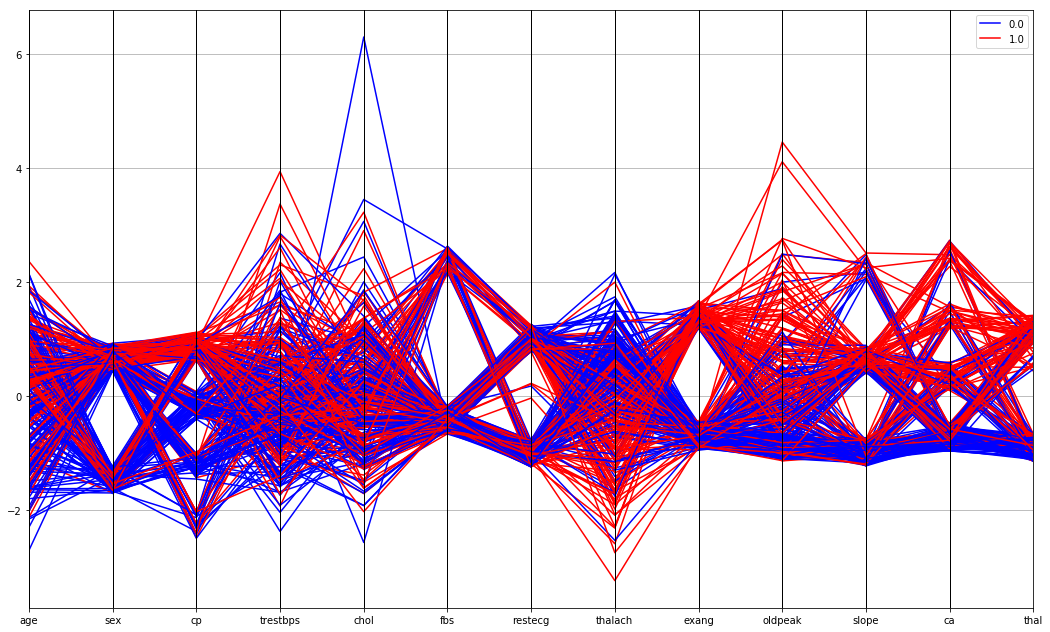

In [17]:
print('Parallel coordinates according to diagnosis:')
df_noisy = df_scaled + (np.random.random(df_scaled.shape) - 0.5)*0.5
df_noisy['diag'] = df_scaled['diag']
plotting.parallel_coordinates(
    frame=df_noisy,
    class_column='diag',
    color=['blue', 'red'],
    xticks=df_noisy.columns[:-1],
).figure.set_figheight(11)

Comparably to the correlation matrix, there are differences between values for healthy and unhealthy patients apparent in some columns. This suggests that even traditional ML algorithms might do a good job.

# Neural networks time!

Let's get going with writing some utilities...

In [18]:
# plotting

def plot_avg_with_minmax_band(x, y, line_kwargs={}, band_kwargs={'alpha':0.3}):
    """Show average across 0th axis as a line and fill space between min and max values"""
    plt.plot(x, y.mean(axis=0), **line_kwargs)
    plt.fill_between(x, y.min(axis=0), y.max(axis=0), **band_kwargs)

def plot_histories(histories, skip_first_n_epochs=0):
    """Show information about the trainings"""
    
    # initialize metric-wise aggregator
    histories_per_metric = {metric:[] for metric in histories[0].keys()}

    # transform the data so that: metric's_name: [metric's_history_1, history_2, ..., history_k]
    for history in histories:
        for metric in histories_per_metric:
            histories_per_metric[metric].append(history[metric])

    # plot every train-valid metric pair separately
    for metric in histories_per_metric.keys():
        if not metric.startswith('val_'):
            # number of epochs
            x = np.arange(1, len(histories_per_metric[metric][0])+1, 1)[skip_first_n_epochs:]

            # results for all epochs and folds
            y_train = np.array(histories_per_metric[metric])[:,skip_first_n_epochs:]
            y_valid = np.array(histories_per_metric['val_'+metric])[:,skip_first_n_epochs:]

            # make the plots
            plot_avg_with_minmax_band(x, y_train)
            plot_avg_with_minmax_band(x, y_valid)

            # add a legend
            plt.legend([metric, 'val_'+metric], fontsize='large')

            # min/max stats
            min_train = y_train.mean(axis=0).min()
            min_valid = y_valid.mean(axis=0).min()
            max_train = y_train.mean(axis=0).max()
            max_valid = y_valid.mean(axis=0).max()

            # add a title with the stats
            plt.title(
                f'{metric.upper()} - '
                f'mean min/max [train: {min_train:0.3}/{max_train:0.3}, '
                f'valid: {min_valid:0.3}/{max_valid:0.3}]'
            )
            
            # label and show
            plt.xlabel('epoch')
            plt.show()

In [19]:
# utilities for metrics
def tensor_length(tensor):
    return K.sum(K.ones_like(tensor))

def count_positives(tensor):
    return K.sum(K.round(K.clip(tensor, 0, 1)))

def reverse(tensor):
    return (-K.clip(tensor, 0, 1)) + 1

# metrics

def sensitivity(y_true, y_pred):
    """
    Measures the sensitivity (recall), i.e.:
    ratio between correctly predicted cases with CVD
    and the actual number of people with CVD.
    """
    pred_true_positives = count_positives(y_true * y_pred)
    actual_positives = count_positives(y_true)
    sensitivity = pred_true_positives / (actual_positives + K.epsilon())
    return sensitivity

def specificity(y_true, y_pred):
    """
    Similar to sensitivity:
    correctly classified healthy cases over
    the actual amount of healthy patients
    """
    pred_true_negatives = count_positives(reverse(y_true)*reverse(y_pred))
    actual_negatives = tensor_length(y_true) - count_positives(y_true)
    specificity = pred_true_negatives / (actual_negatives + K.epsilon())
    return specificity

Split features and labels

In [20]:
# TensorFlow cannot train with NaN values, fill them with a corresponding median value
df_scaled.fillna(df_scaled.median(), inplace=True)

# all but the last column as a NumPy array
X = df_scaled.values[:,:-1]

# get the answers as an arary
Y = df_scaled['diag'].values

For most of the experimenting with network architecture and hyperparameters, I was using the following cell as a basis, I did not have time and nerves to make a *"fancy"* (more automated?) setup. I copied the cell many times and always changed something, then reran to see the results.

My strategy was to first find several simple models that were overfitting and could reach 100% accuracy, then I was iterating changes (dropout, batch normalization, batch size, slight changes to architecture, etc.) to generalize the learning, I was mostly interested in scoring well on the sensitivity metrics - in my opinion, it is more important to diagnoze CVD early rather than too late.

I will show my 3 picks of interesting models that I have come across during the endeavor. Graphs for each model will show average training and validation loss, accuracy, sensitivity and specificity, each represented by a line (average taken from cross validation), the graphs also contain bands around the metrics' lines which represent the maxima and minima for a metric per epoch.

### Wide-and-flat model

Following model has only one hidden layer of 64 neurons, it turned out to be quite expressive and reacted well to batch normalization and dropout - postponing overfitting by more than factor of two and improving metrics.

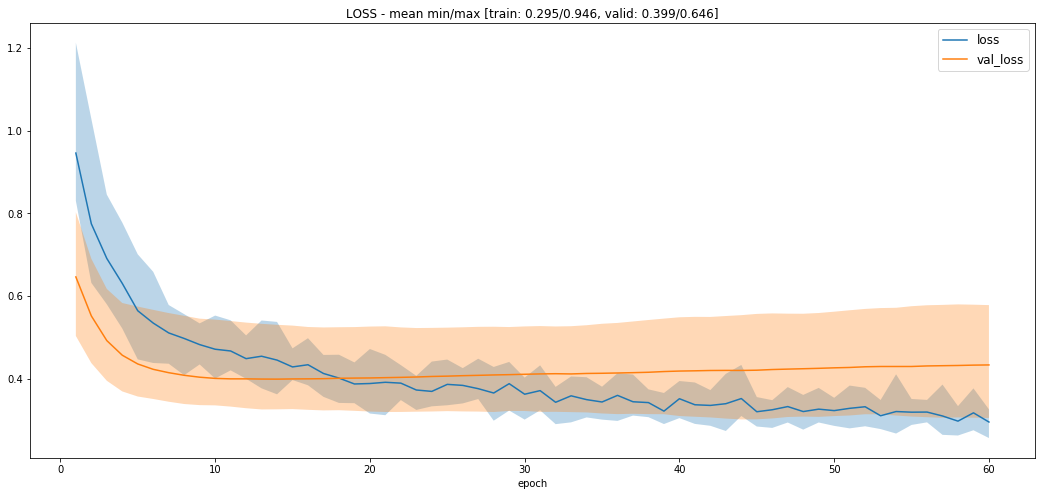

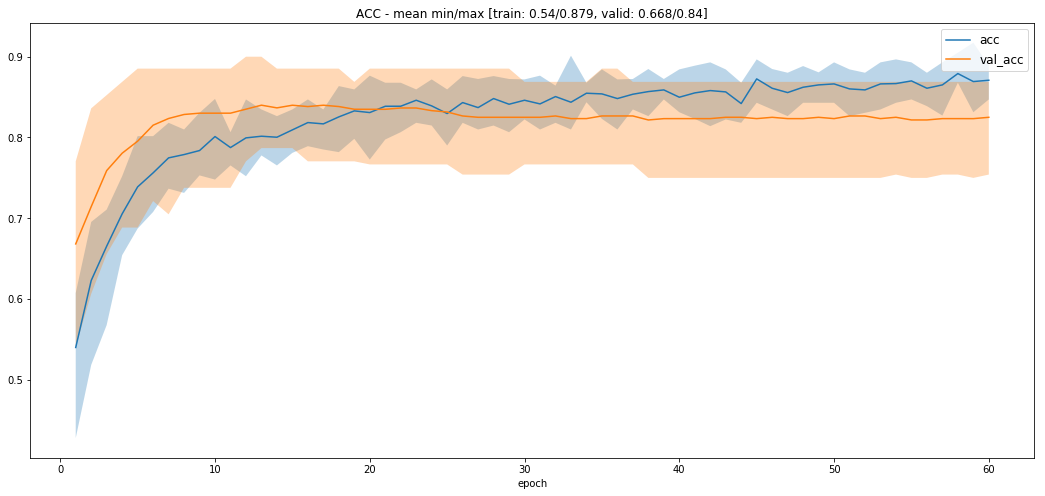

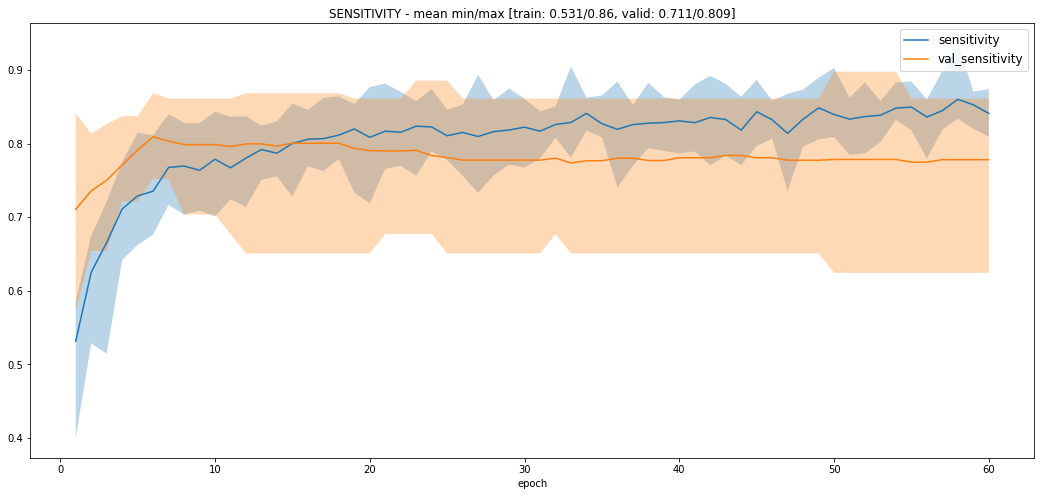

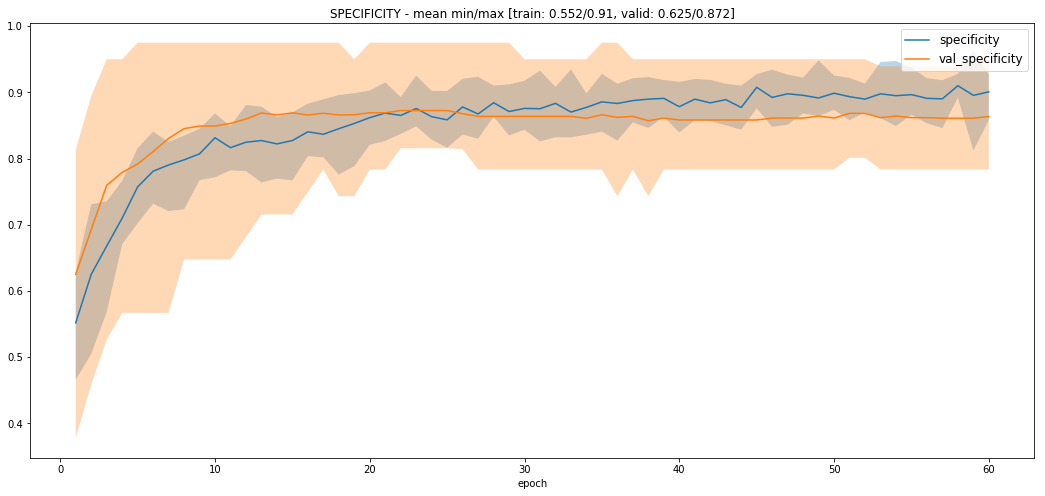

In [21]:
kfold = RepeatedKFold(n_splits=5, n_repeats=2)
histories = [] # a history of training histories
for train_index, valid_index in kfold.split(X):
    
    training_no = len(histories) + 1
    print(f'Training/round #{training_no}', end='\r')
    
    # current split
    x_train, y_train = X[train_index], Y[train_index]
    validation_data  = X[valid_index], Y[valid_index]
    
    model = keras.Sequential()

    model.add(Dense(64, activation='relu', input_shape=(13,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', sensitivity, specificity],
    )
    
    fit = model.fit(
        x_train, y_train,
        validation_data=validation_data,
        epochs=60,
        batch_size=32,
        verbose=0,
    )
    
    histories.append(fit.history)

plot_histories(histories)

### Tube model

I call this model a "tube" because it has 3 hidden layers and all are the same size - 24 neurons.
Its basic performance is very good, however, it is too expressive and it is hard to fight overfitting.

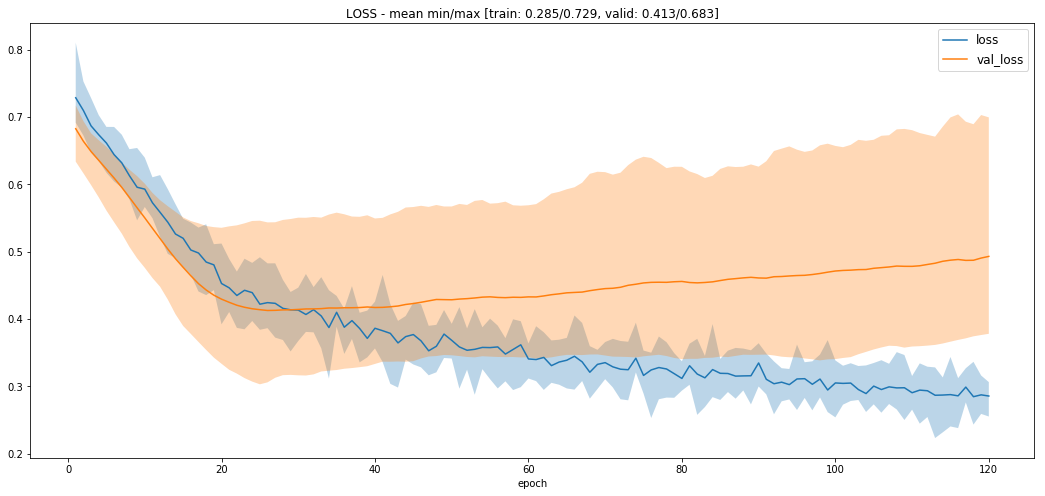

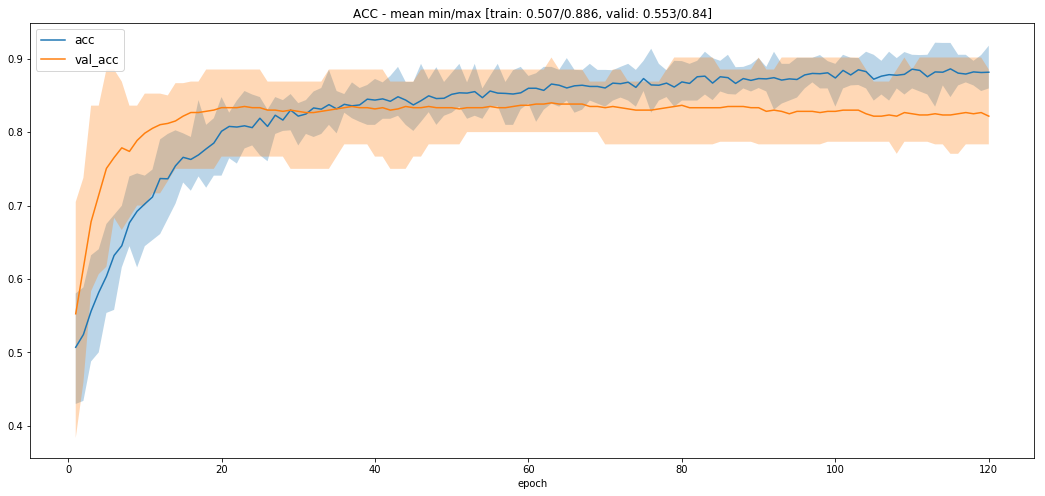

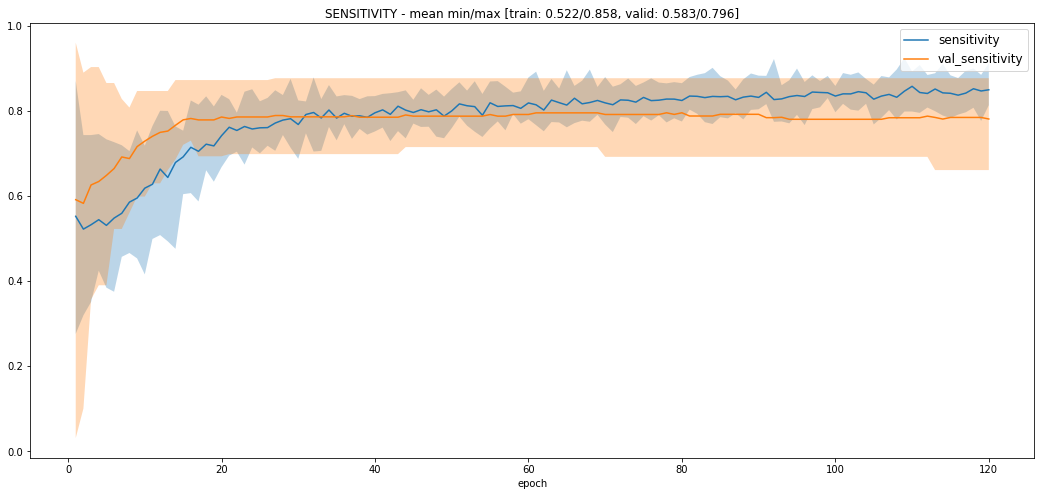

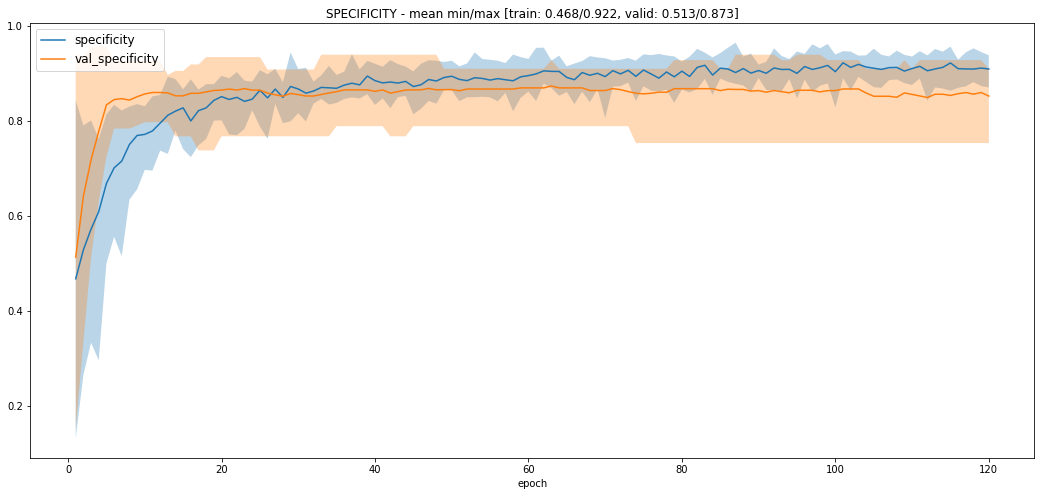

In [22]:
kfold = RepeatedKFold(n_splits=5, n_repeats=2)
histories = [] # a history of training histories
for train_index, valid_index in kfold.split(X):
    
    training_no = len(histories) + 1
    print(f'Training/round #{training_no}', end='\r')
    
    # current split
    x_train, y_train = X[train_index], Y[train_index]
    validation_data  = X[valid_index], Y[valid_index]
    
    model = keras.Sequential()

    model.add(Dense(24, activation='relu', input_shape=(13,)))
    model.add(Dropout(0.3))
    model.add(Dense(24, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(24, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', sensitivity, specificity],
    )
    
    fit = model.fit(
        x_train, y_train,
        validation_data=validation_data,
        epochs=120,
        batch_size=32,
        verbose=0,
    )
    
    histories.append(fit.history)

plot_histories(histories)

### The pyramid

This model has two hidden layers, first one with 13 neuron, second with 7, its basic performance is great and behaves excellent towards batch normalization and dropout, it is a slow learner but very general. I've achieved the best results with this model.

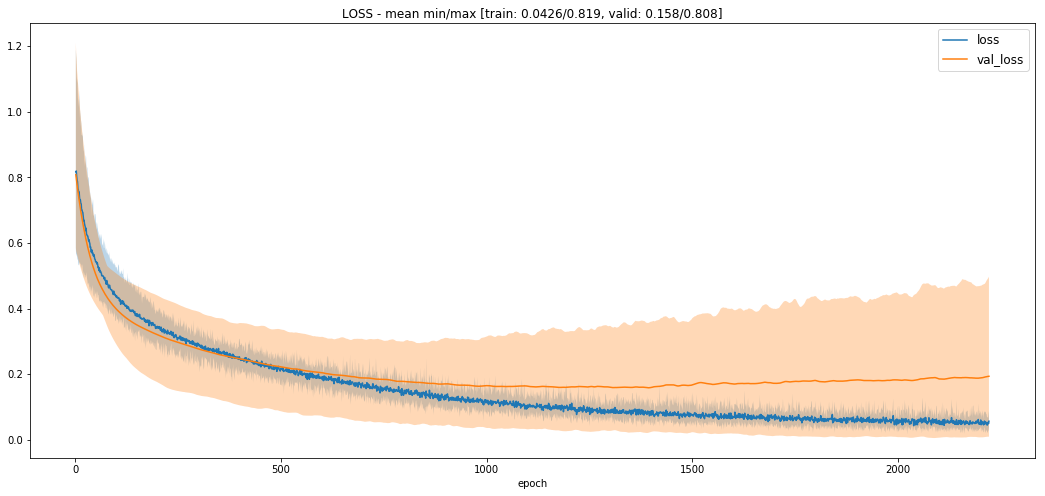

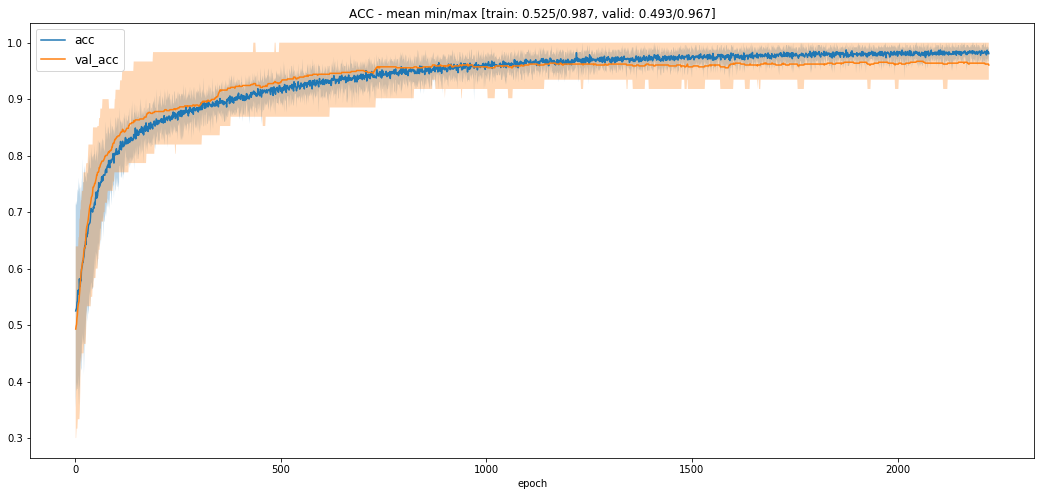

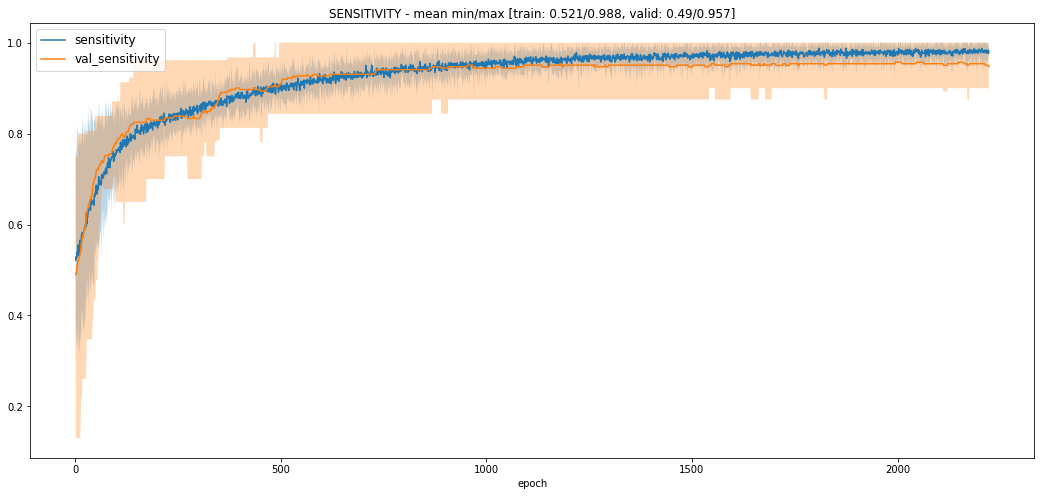

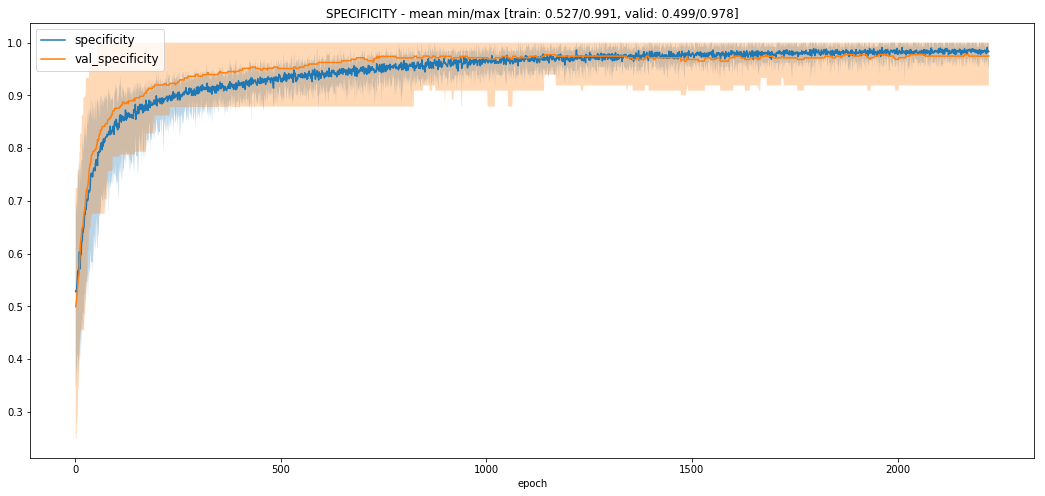

In [23]:
kfold = RepeatedKFold(n_splits=5, n_repeats=2)
histories = [] # a history of training histories
for train_index, valid_index in kfold.split(X):
    
    training_no = len(histories) + 1
    print(f'Training/round #{training_no}', end='\r')
    
    # current split
    validation_data  = X[valid_index], Y[valid_index]
    
    model = keras.Sequential()

    model.add(Dense(13, activation='relu', input_shape=(13,)))
    model.add(BatchNormalization())
    model.add(Dropout(2/13))
    model.add(Dense(7, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', sensitivity, specificity],
    )
    
    fit = model.fit(
        x_train, y_train,
        validation_data=validation_data,
        batch_size=256, # taking whole dataset, trains and learns faster than with just parts of it
        epochs=2222,    # needs many epochs then 
        verbose=0,
    )
    
    histories.append(fit.history)

plot_histories(histories)

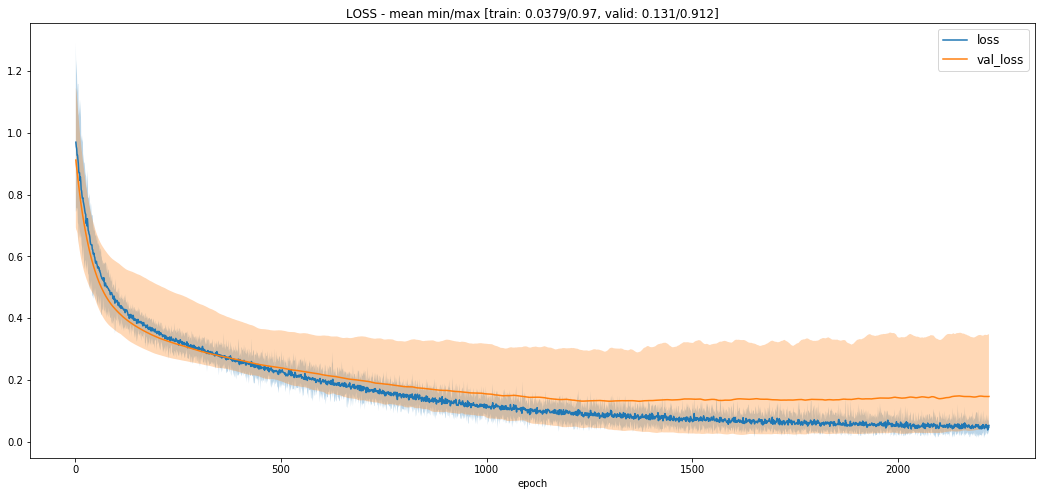

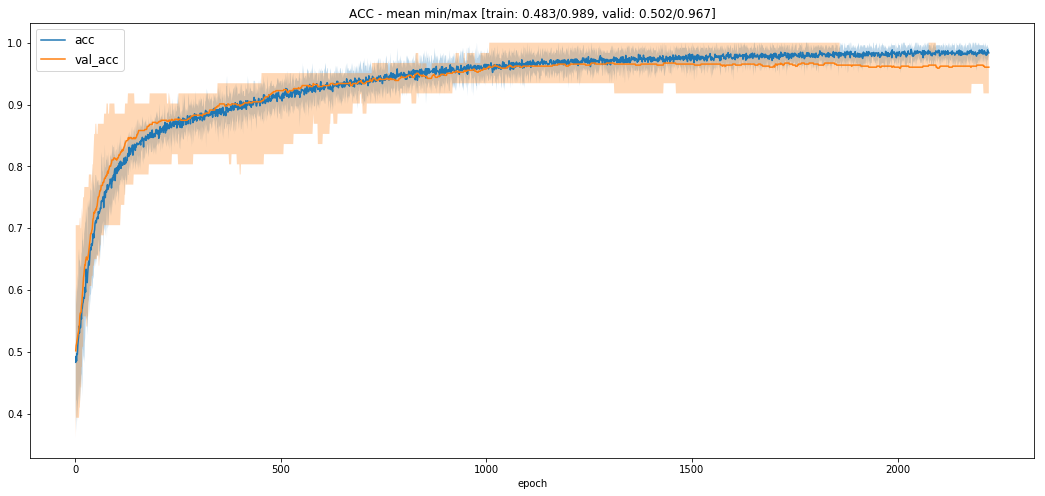

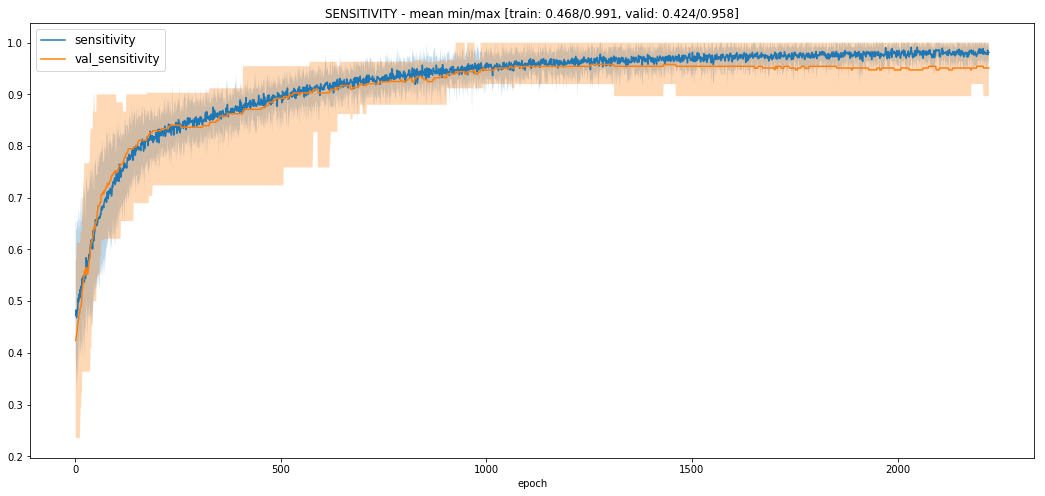

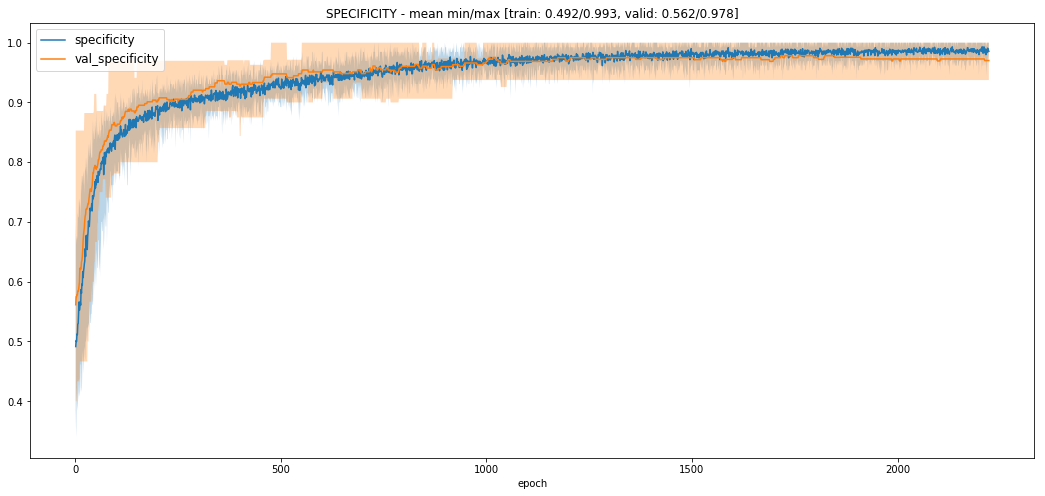

In [26]:
kfold = RepeatedKFold(n_splits=5, n_repeats=2)
histories = [] # a history of training histories
for train_index, valid_index in kfold.split(X):
    
    training_no = len(histories) + 1
    print(f'Training/round #{training_no}', end='\r')
    
    # current split
    validation_data  = X[valid_index], Y[valid_index]
    
    model = keras.Sequential()

    model.add(Dense(13, activation='relu', input_shape=(13,)))
    model.add(BatchNormalization())
    model.add(Dropout(2/13))
    model.add(Dense(8, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', sensitivity, specificity],
    )
    
    fit = model.fit(
        x_train, y_train,
        validation_data=validation_data,
        batch_size=256, # taking whole dataset, trains and learns faster than with just parts of it
        epochs=2222,    # needs many epochs then 
        verbose=0,
    )
    
    histories.append(fit.history)

plot_histories(histories)

# Conclusions

Due to the dataset having only 303 rows, it does not give much sense to build and train large networks as such set can be easily memorized. That also means that results might be very inconsistent, in order to increase consistency, I was using repeated k-fold - usually 5 splits, repeated twice - with this setting the training was reasonably fast and results fluctuated by mostly less than 5%.

With the last model I was consistently reaching accuracy and sensitivity more than 95%, 94% for specificity. In contrast, mere guessing that a person is healthy would result in ~54% accuracy. I am happy with the results given that it was quite difficult to be steadily reaching sensitivity of more than 80% (accuracy and specificity were usually higher). On the other hand, this results might be much lower on an actual test dataset.

Results could be further improved especially by extending the dataset (e.g. using the other datasets from the database) and by additional improvements to the model. A more elaborate validation technique would be beneficial, too.